# Problème Inverse

## Codes préliminaires

In [1]:
import import_ipynb ##Il faut exécuter "pip install import-ipynb" sur un terminal auparavant

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from numerical_tour import*

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import random as rd
from time import process_time

plt.rcParams['text.usetex'] = False
rd.seed(10)
eps = np.finfo(float).eps

importing Jupyter notebook from numerical_tour.ipynb


# I - Traitement d'un signal

## Simulation

In [2]:
#Génération des données

T = 100 
K = 15 #Eléments non nuls

ind = np.unique(rd.sample(range(1,T),K))

values = np.random.normal(0,1,size = np.shape(ind))

x = np.zeros(T)
x[ind] = values


In [3]:
#Simulation de x
M = 50
A = np.random.normal(0,1,size=(M,T))


In [4]:
#Simulation du bruit blanc
inputSNR = 9
sigma = np.linalg.norm(A@x)**2*10**(-inputSNR/10)/M
e = np.random.normal(0,sigma,size = M)
y = A@x + e

checksnr = 20*np.log10(np.linalg.norm(A@x)/np.linalg.norm(A@x-y))
print('SNR =',checksnr)

SNR = 6.297486951095942


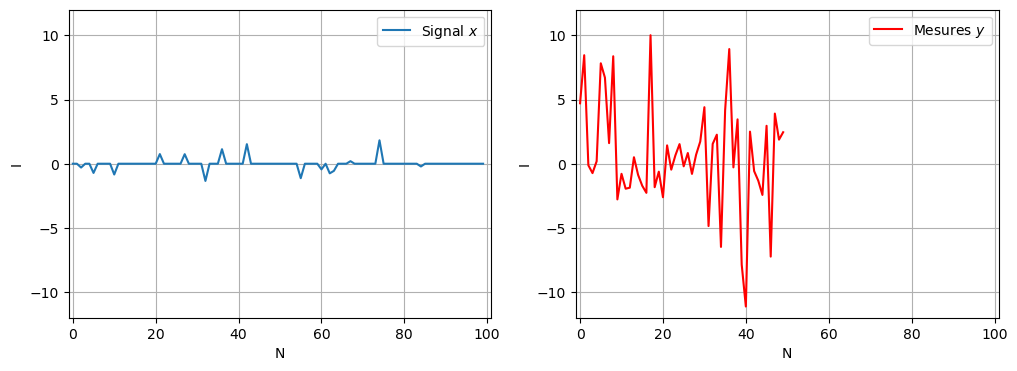

In [5]:
#Représentation de x et y
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(x, label = 'Signal $x$')
ax[0].set_xlabel('N')
ax[0].set_ylabel('I')
ax[0].grid()
ax[0].set_xlim([-1,101])
ax[0].set_ylim([-12,12])
ax[0].legend()

ax[1].plot(y, label = 'Mesures $y$',color = 'r')
ax[1].set_xlabel('N')
ax[1].set_ylabel('I')
ax[1].grid()
ax[1].set_xlim([-1,101])
ax[1].set_ylim([-12,12])
ax[1].legend()

plt.show()

## Algorithmes ISTA et FISTA

In [6]:
#Algorithme ISTA

def ISTA(A,x,y,N,lambd):
    L = np.linalg.norm(A,ord = 2)**2
    x_est = np.transpose(A)@y
    e = lambd/L
    
    t_list = [0]
    x_list = [x_est]
    cout_list = [np.linalg.norm(x_est)]
    
    for i in range(N): 
        t1 = process_time()
        x_est = x_est + np.transpose(A)@(y-A@x_est)/L
        x_est = x_est*np.maximum(np.zeros(len(x_est)),1-e/(np.abs(x_est)+eps))
        t2 = process_time()
        
        t_list.append(t_list[i-1]+t2-t1)
        x_list.append(x_est)
        cout_list.append(np.linalg.norm(x_est-x_list[i-1]))
        
    SNR = 20*np.log10(np.linalg.norm(x)/np.linalg.norm(x-x_est))
    
    return SNR,t_list,cout_list,x_est
    
SNR = ISTA(A,x,y,500,1)[0]
print('SNR = ',SNR)


SNR =  2.395780473457098


In [7]:
#Algorithme FISTA

def FISTA(A,x,y,N,lambd):
    L = np.linalg.norm(A,ord = 2)**2
    e = lambd/L
    x_est = np.transpose(A)@y
    z_est = x_est
    
    t_list = [0]
    x_list = [x_est]
    cout_list = [np.linalg.norm(x_est)]
    
    for i in range(N):
        t1 = process_time()
        x_est_old = x_est
        x_est = z_est + np.transpose(A)@(y-A@z_est)/L
        x_est = x_est*np.maximum(np.zeros(len(x_est)),1-e/(np.abs(x_est)+eps))
        z_est = x_est + i/(i+5)*(x_est-x_est_old)
        
        t2 = process_time()
        
        t_list.append(t_list[i-1]+t2-t1)
        x_list.append(x_est)
        cout_list.append(np.linalg.norm(x_est-x_list[i-1]))
    
    SNR = 20*np.log10(np.linalg.norm(x)/np.linalg.norm(x-x_est))
        
    return SNR,t_list,cout_list,x_est

SNR = FISTA(A,x,y,500,1)[0]
print('SNR = ',SNR)


SNR =  2.8071248987159785


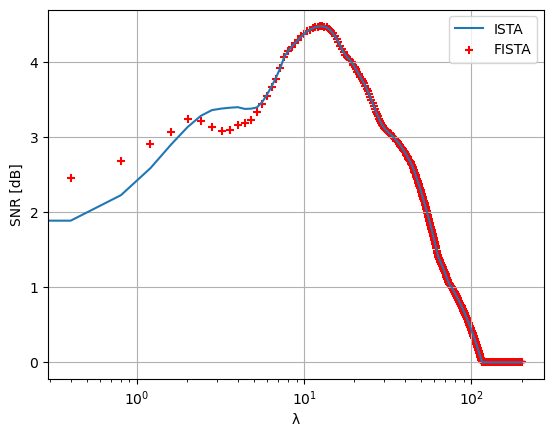

4.475700753496864


In [8]:
#Comparaison ISTA FISTA
l_list = np.linspace(0,200,500)
SNR_list = []
FSNR_list = []

for l in l_list:
    SNR_list.append(ISTA(A,x,y,500,l)[0])
    FSNR_list.append(FISTA(A,x,y,500,l)[0])
    
plt.figure()
plt.plot(l_list,SNR_list,label = 'ISTA')
plt.scatter(l_list,FSNR_list,label = 'FISTA',color = 'r', marker = '+')
plt.grid()
plt.xlabel('λ')
plt.ylabel('SNR [dB]')
plt.xscale('log')
plt.legend()
plt.show()

print(np.max(SNR_list))

In [9]:
#Optimisation de lambda
lmbd_opt = l_list[np.argmax(FSNR_list)]
print(lmbd_opt)

12.424849699398798


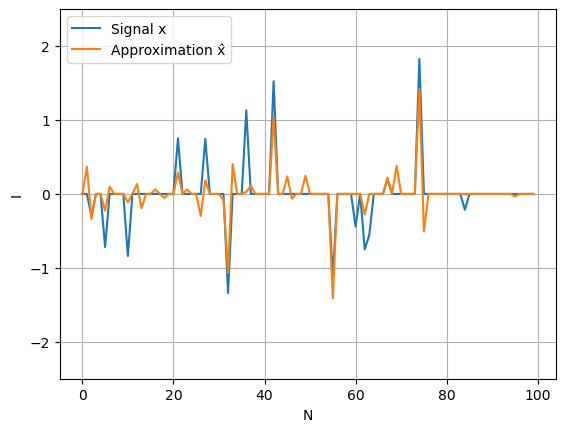

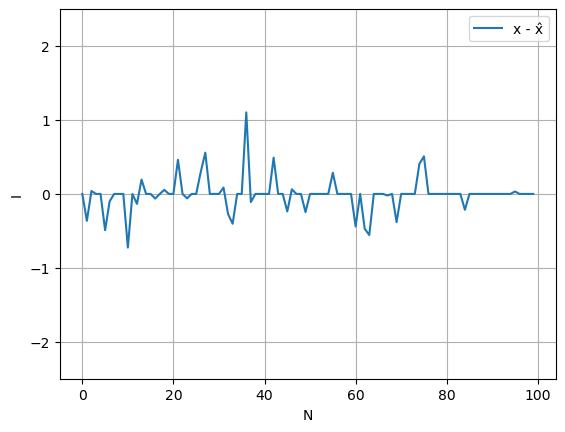

In [10]:
#Représentations de l'approximation
x_est = FISTA(A,x,y,500,lmbd_opt)[3]
fig = plt.figure()
plt.plot(x, label = "Signal x")
plt.plot(x_est, label = "Approximation x̂")
plt.xlabel('N')
plt.ylabel('I')
plt.ylim([-2.5,2.5])
plt.grid()
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(x-x_est, label = "x - x̂")
plt.xlabel('N')
plt.ylabel('I')
plt.ylim([-2.5,2.5])
plt.grid()
plt.legend()
plt.show()

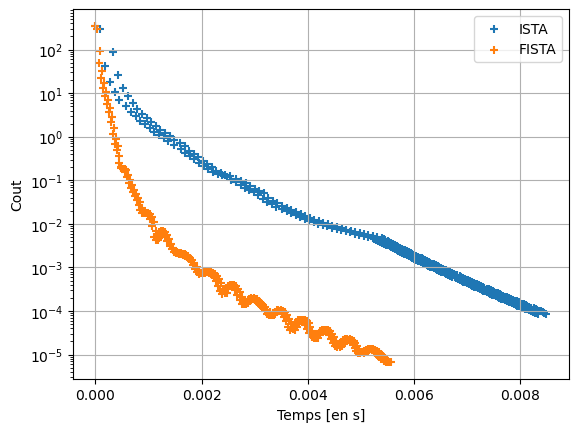

In [11]:
#Calcul du cout

SNR1, t1, c1, dum = ISTA(A,x,y,300,lmbd_opt)
SNR2, t2, c2, dum = FISTA(A,x,y,300,lmbd_opt)

fig = plt.figure()
plt.scatter(t1,c1, marker = '+', label = 'ISTA')
plt.scatter(t2,c2, marker = '+', label = 'FISTA')
plt.xlabel('Temps [en s]')
plt.ylabel('Cout')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

## Warm restart

In [12]:
#Ista avec Warm restart 
def ISTAW(A,x,y,Nl,Nbit):
    L = np.linalg.norm(A,ord = 2)**2
    x_est = np.transpose(A)@y
    
    lambdaMax = np.max(np.abs((np.transpose(A)@y)))
    lambdaMin = 1e-8*lambdaMax;
    
    Lambda_list = np.logspace(np.log10(lambdaMin),np.log10(lambdaMax),Nl)
    SNR_list = []
    
    for l in Lambda_list :
        e = l/L
        for i in range(Nbit):
            x_est = x_est + np.transpose(A)@(y-A@x_est)/L
            x_est = x_est*np.maximum(np.zeros(len(x_est)),1-e/(np.abs(x_est)+eps))

        SNR = 20*np.log10(np.linalg.norm(x)/np.linalg.norm(x-x_est))
        SNR_list.append(SNR)
        
    return Lambda_list,SNR_list

lambd1, SNR1 = ISTAW(A,x,y,300,1000)


In [13]:
#FISTA avec Warm restart
def FISTAW(A,x,y,Nl,Nbit):
    L = np.linalg.norm(A,ord = 2)**2
    x_est = np.transpose(A)@y
    z_est = x_est
    
    lambdaMax = np.max(np.abs((np.transpose(A)@y)))
    lambdaMin = 1e-8*lambdaMax;
    
    Lambda_list = np.logspace(np.log10(lambdaMin),np.log10(lambdaMax),Nl)
    SNR_list = []
    
    for l in Lambda_list :
        e = l/L
        for i in range(Nbit):
            x_est_old = x_est
            x_est = z_est + np.transpose(A)@(y-A@z_est)/L
            x_est = x_est*np.maximum(np.zeros(len(x_est)),1-e/(np.abs(x_est)+eps))
            z_est = x_est + i/(i+5)*(x_est-x_est_old)

        SNR = 20*np.log10(np.linalg.norm(x)/np.linalg.norm(x-x_est))
        SNR_list.append(SNR)
        
    return Lambda_list,SNR_list

lambd2, SNR2 = FISTAW(A,x,y,300,1000)


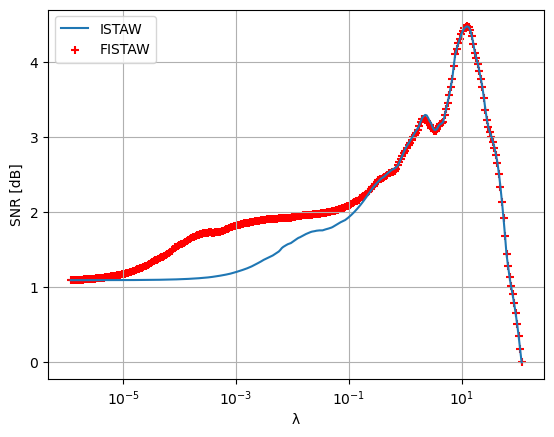

In [14]:
plt.figure()
plt.plot(lambd1,SNR1,label = 'ISTAW')
plt.scatter(lambd1,SNR2,label = 'FISTAW',marker = '+',color = 'r')
plt.grid()
plt.xlabel('λ')
plt.ylabel('SNR [dB]')
plt.xscale('log')
plt.legend()
plt.show()


# II - Traitement d'image

## Bruitage d'image

(128, 128)


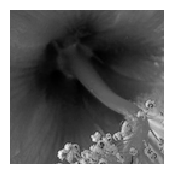

In [15]:
#Représentation de l'image originale

n = 128
f0 = load_image("hibiscus.bmp")
f0 = rescale(f0[256-n//2:256+n//2,256-n//2:256+n//2])

plt.figure(figsize=(2,2))
imageplot(f0)

print(np.shape(f0))

In [16]:
#Définition de la fonction bruit
rho = 0.5
A = np.zeros([n,n])
sel = np.random.permutation(n**2)
np.ravel(A)[sel[np.arange(int(rho*n**2))]] = 1 ##Opérateur de norme 1

def Phi(f, A):
    return f*(1-A)

y = Phi(f0, A)

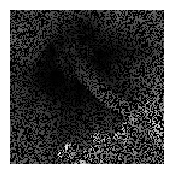

In [17]:
#Représentation de l'image bruitée
plt.figure(figsize=(2,2))
imageplot(y)

## Débruitage

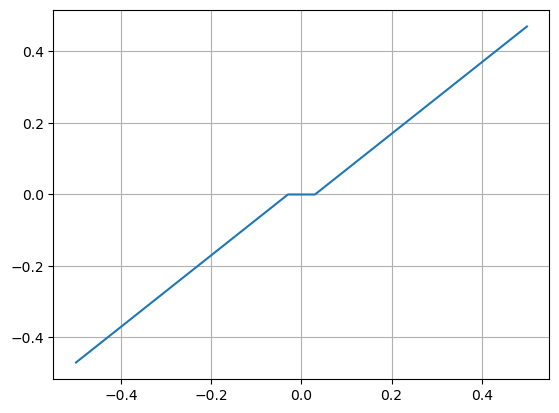

In [18]:
#Définition et représentation de l'opérateur de seuillage

def S(x, T): 
    return x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

x = np.linspace(-0.5, 0.5, 1000)

plt.figure()
plt.plot(x, S(x,0.03))
plt.grid()
plt.show()

In [19]:
#Transformées en ondelettes et opérateur final
Jmin = (np.log2(n//2)-2)

def Omega(a): 
    return perform_wavelet_transf(a, Jmin, -1, ti=0)
def OmegaT(f): 
    return perform_wavelet_transf(f, Jmin, +1, ti=0)

def S_final(f, T): 
    return Omega(S(OmegaT(f), T))

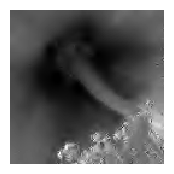

In [20]:
#Algorithme ISTA
lambd = 0.03
fSpars = y

for i in range(500):
    fSpars = A*fSpars + (1-A)*y
    fSpars = S_final(fSpars, lambd)

plt.figure(figsize=(2,2))
imageplot(clamp(fSpars))